In [1]:
import os
import sys

import astropy.units as u
import numpy as np
import matplotlib.pyplot as pl
%matplotlib inline

from scipy.optimize.slsqp import approx_jacobian

project_path = "/Users/adrian/projects/kinematic-consensus/"
if project_path not in sys.path:
    sys.path.append(project_path)
import kingkong

In [63]:
# v = [-0.8218560647450601, -0.5578178790957554, -0.1157230426616782]
# theta = 3.9010707651854575
# q = kingkong.util.Quaternion.from_v_theta(v, theta)
q = None

np.random.seed(42)
mock = kingkong.MockStream(r0=11., v0=0.8, nsteps_per_period=256,
                           quaternion=q)

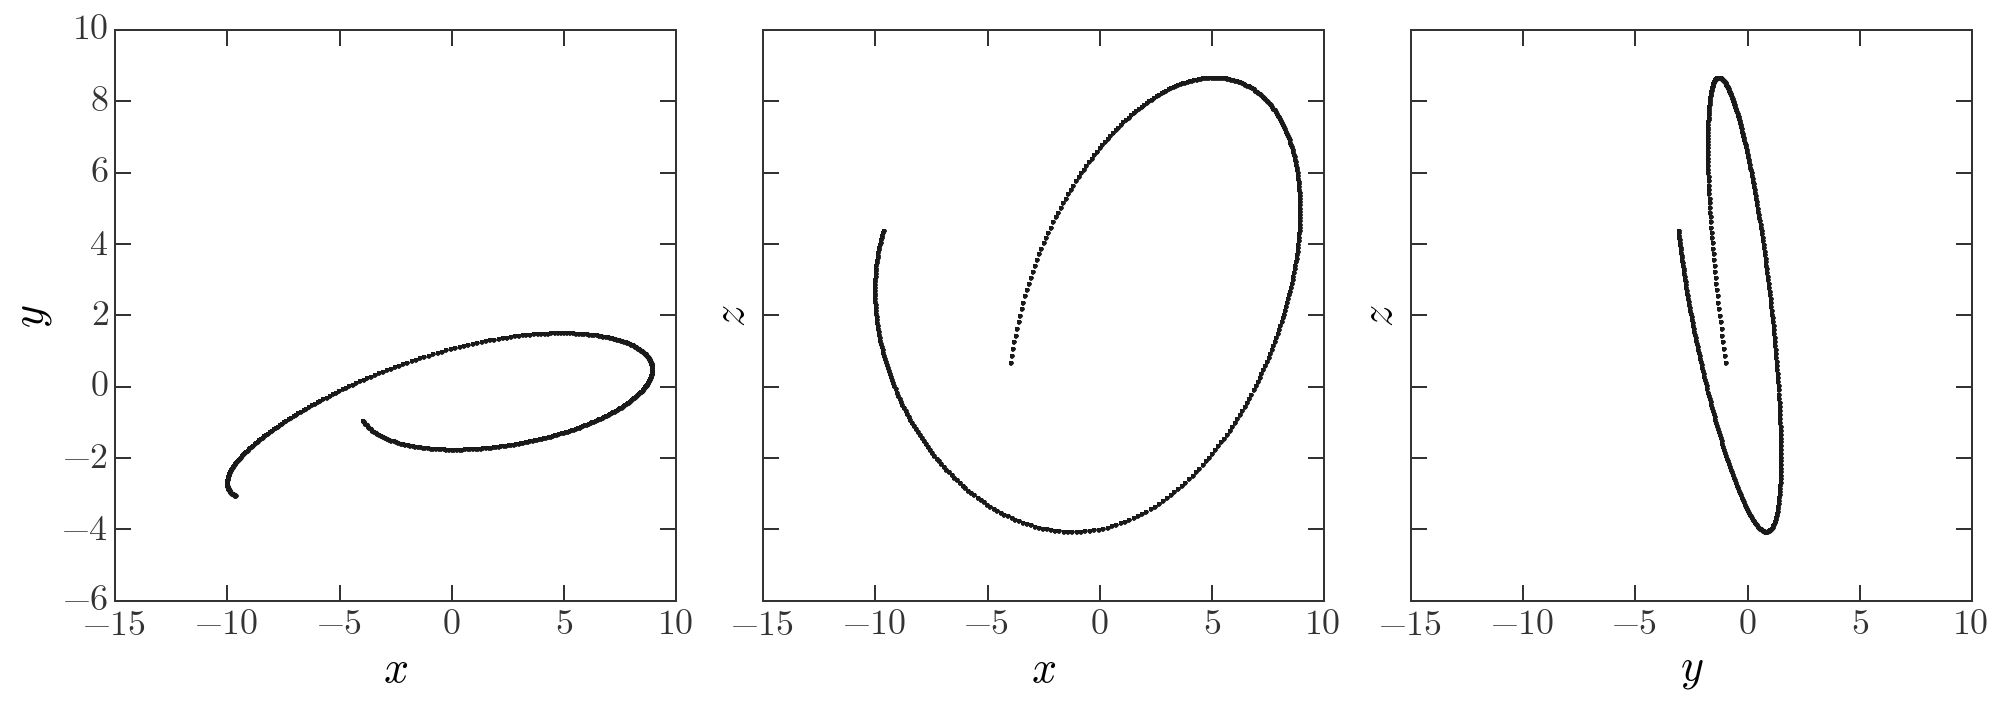

In [64]:
fig = mock.plot()

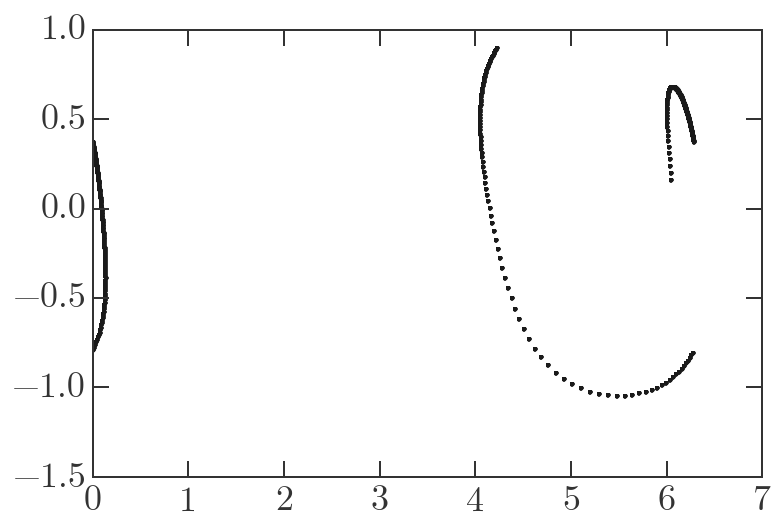

In [65]:
Y = kingkong.cartesian_to_spherical(kingkong.galactocentric_to_heliocentric(mock.X))
pl.plot(Y[:,0], Y[:,1], ls='none')

In [72]:
VX = (np.array([0.01,0.01,0.01,0.001,0.001,0.001])*1.)**2
rootVX = np.sqrt(VX)
Xspread = np.random.normal(mock.X, np.sqrt(VX), size=(256,)+mock.X.shape)

In [73]:
Yspread = kingkong.cartesian_to_spherical(kingkong.galactocentric_to_heliocentric(Xspread))

In [74]:
func = lambda x: kingkong.cartesian_to_spherical(kingkong.galactocentric_to_heliocentric(x))

rootVY = np.zeros_like(Y)
for i in range(len(mock.X)):
    J = approx_jacobian(mock.X[i], func, 0.001)
    cov = np.diag(VX)
    rootVY[i] = np.sqrt(np.diag(J.dot(cov).dot(J.T)))

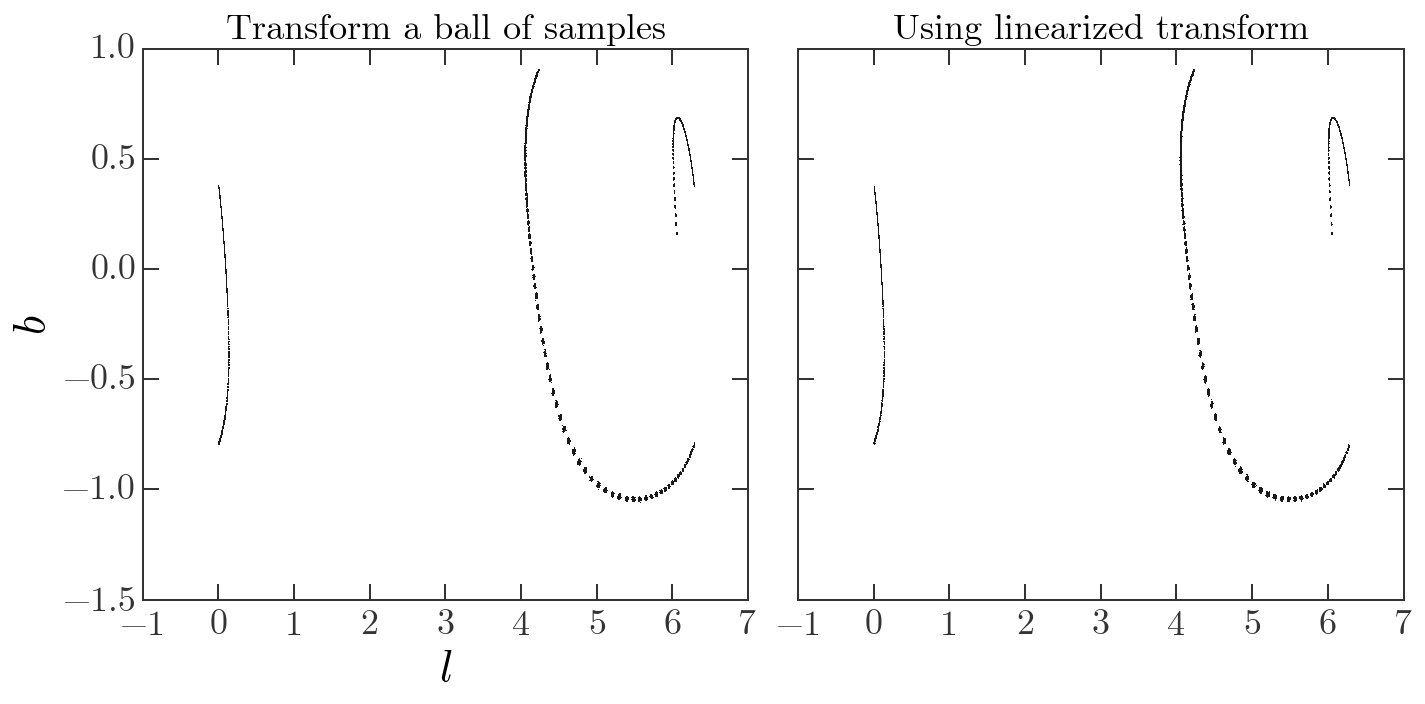

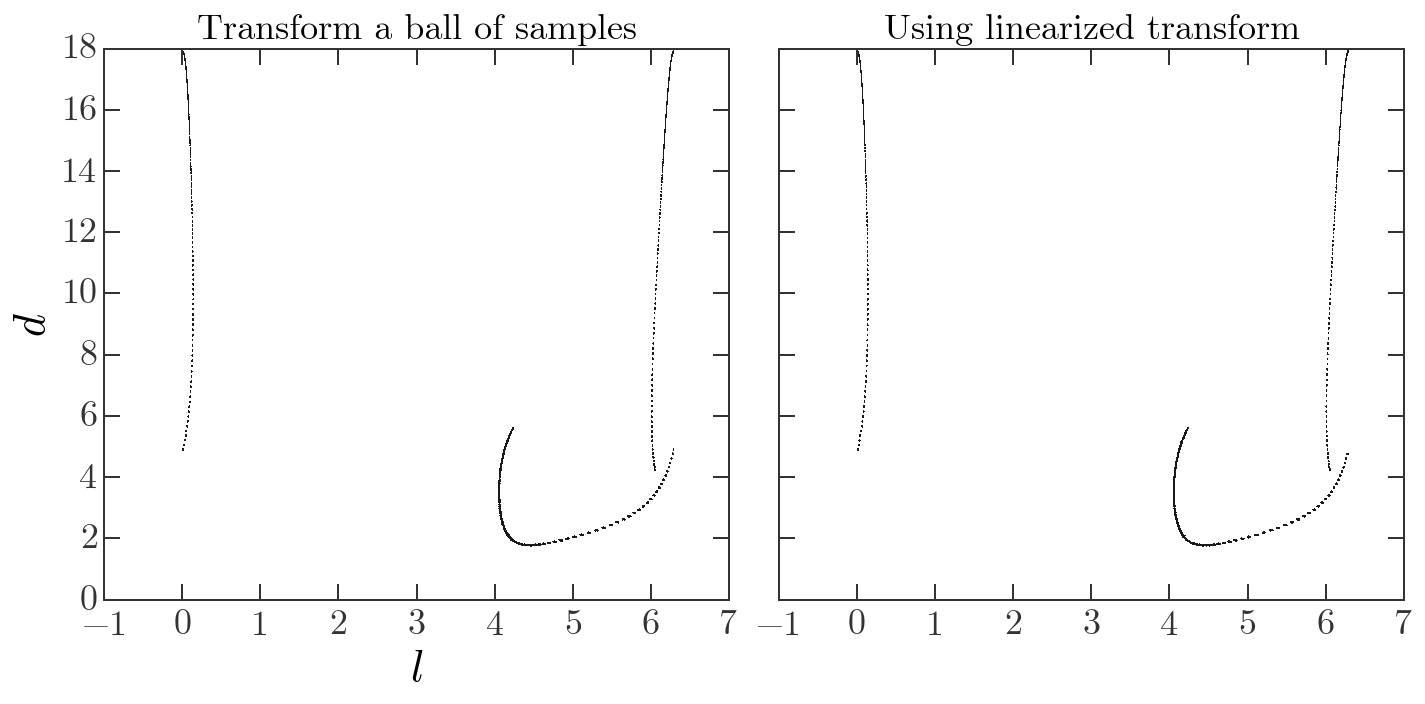

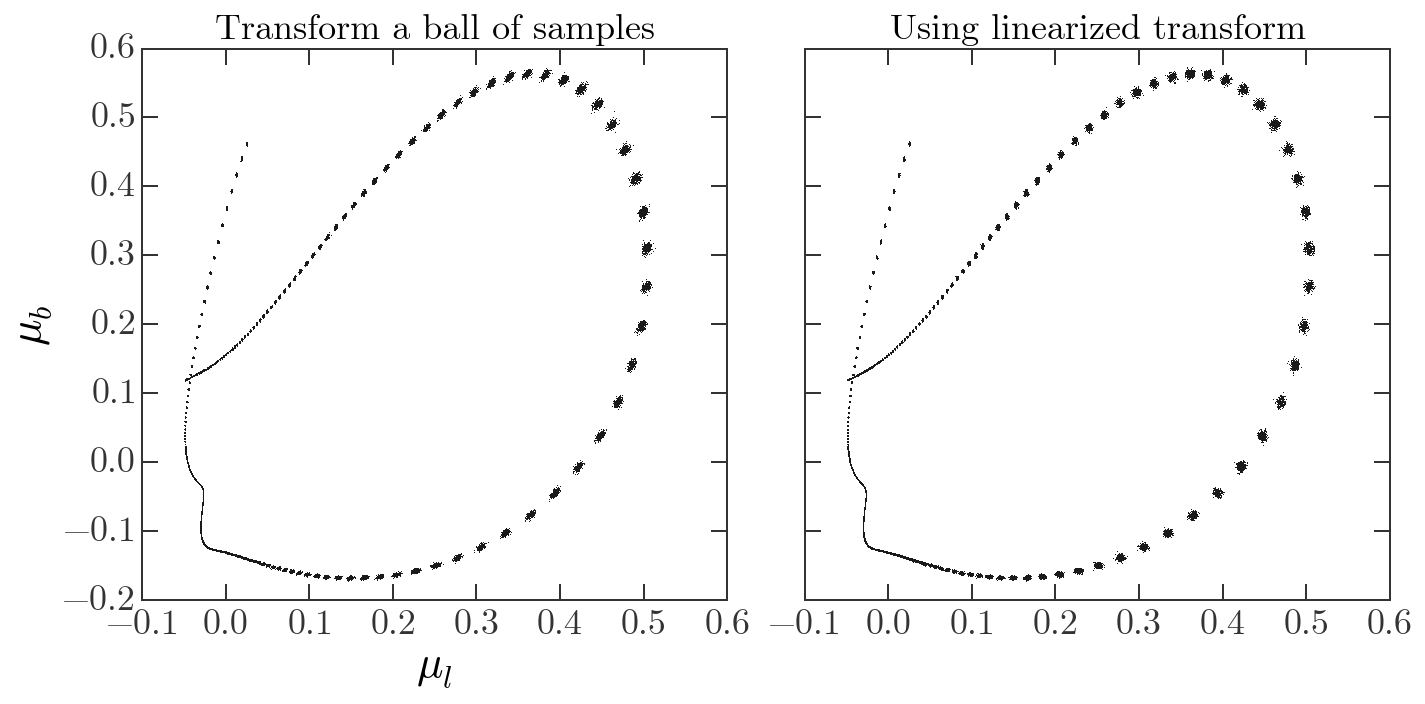

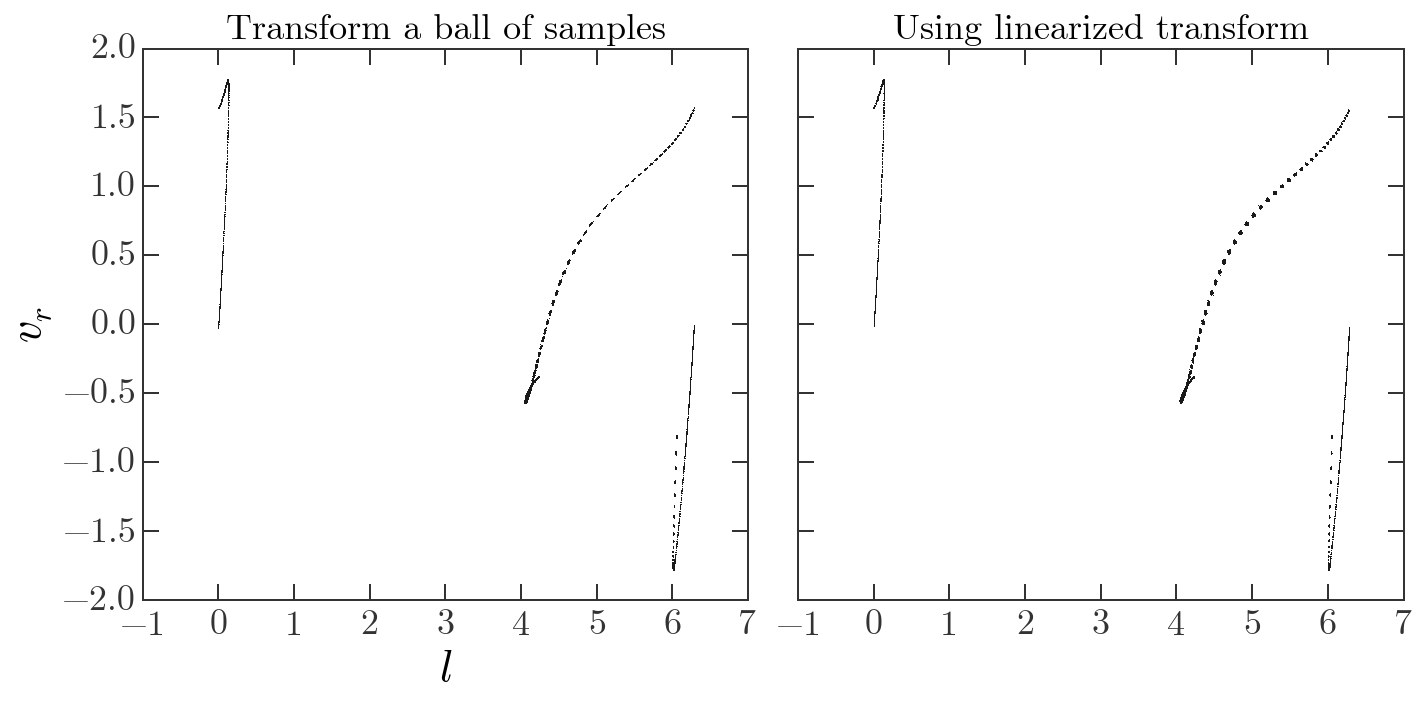

In [79]:
labels = [('$l$','$b$'), ('$l$','$d$'), (r'$\mu_l$',r'$\mu_b$'), ('$l$', '$v_r$')]
idxs = [(0,1), (0,2), (3,4), (0,5)]
ptkwargs = dict(alpha=1., marker=',', ls='none')

for (xl,yl),(ix1,ix2) in zip(labels, idxs):
    fig,axes = pl.subplots(1, 2, figsize=(10,5), sharex=True, sharey=True)
    
    axes[0].plot(Yspread[...,ix1].ravel(), Yspread[...,ix2].ravel(), **ptkwargs)
#     pl.plot(Y[:,ix1] + 2*rootVY[:,ix1], Y[:,ix2] + 2*rootVY[:,ix2], marker=None, lw=1., color='r')
#     pl.plot(Y[:,ix1] - 2*rootVY[:,ix1], Y[:,ix2] - 2*rootVY[:,ix2], marker=None, lw=1., color='r')
    axes[0].set_xlabel(xl); axes[0].set_ylabel(yl)
        
    Yspread2 = np.random.normal(Y, rootVY, size=(256,)+Y.shape)
    axes[1].plot(Yspread2[...,ix1].ravel(), Yspread2[...,ix2].ravel(), **ptkwargs)
    
    axes[0].set_title("Transform a ball of samples", fontsize=18)
    axes[1].set_title("Using linearized transform", fontsize=18)
    fig.tight_layout()